In [1]:
!pip install pytesseract pillow

In [2]:
!apt-get install tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (8,214 kB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 123632 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-

In [ ]:
!rm -rf /content/extracted_texts
!rm -rf /content/processed_images
!rm -rf    /content/ocr_text


In [ ]:
import os
import glob

# Folder path
folder_path = "/content/invoice/images"

# Patterns to match
patterns = ["*_thresholded.*", "*_resized.*","*_enhanced.*","*_enhanced_rescaled.*","*_rescaled.*"]

# Loop through patterns and remove matching files
for pattern in patterns:
    # Create the full pattern path
    full_pattern = os.path.join(folder_path, pattern)
    # Get the list of files matching the pattern
    files_to_remove = glob.glob(full_pattern)
    for file_path in files_to_remove:
        try:
            os.remove(file_path)  # Remove the file
            print(f"Removed: {file_path}")
        except Exception as e:
            print(f"Error removing {file_path}: {e}")


Saving Template1_Instance165.jpg to Template1_Instance165.jpg


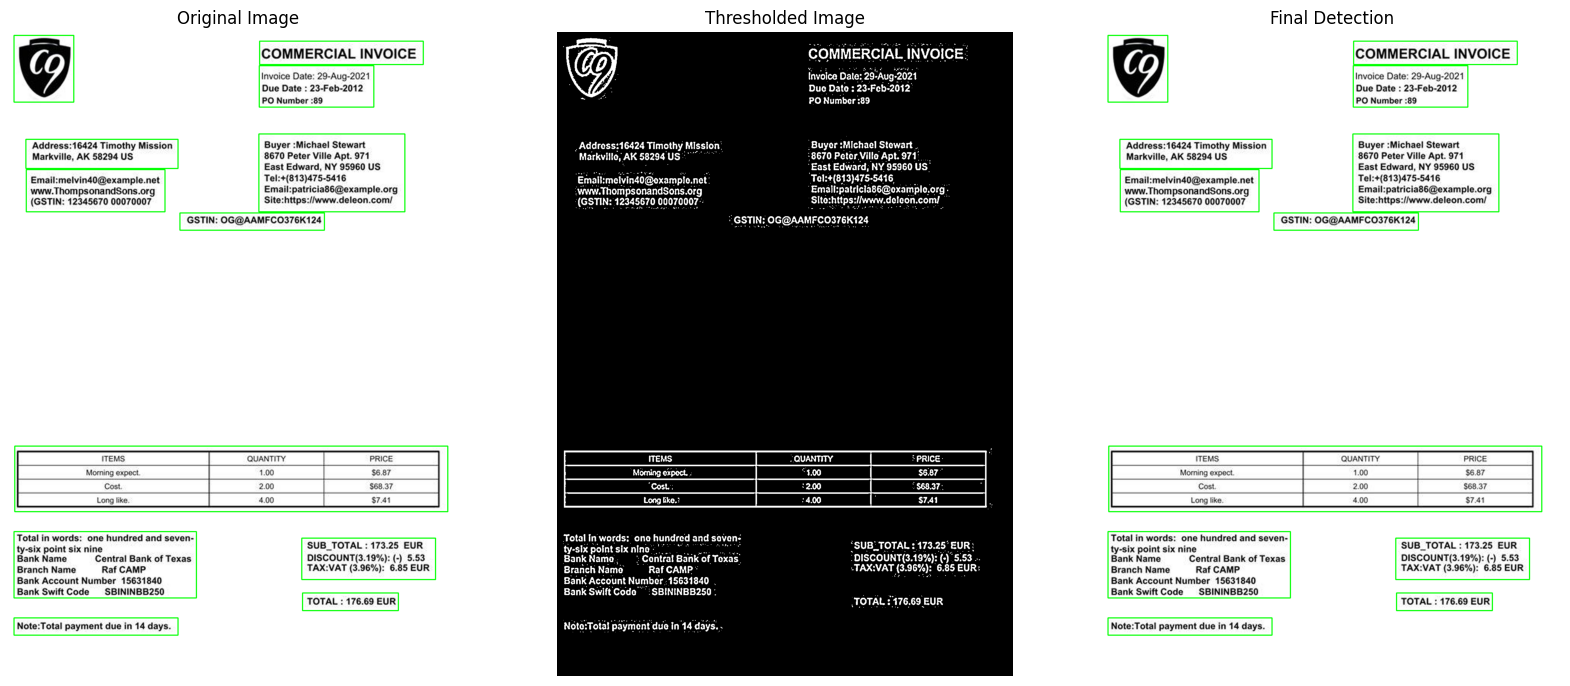

['', 'COMMERCIAL INVOICE', 'Invoice Date: 29-Aug-2021\nDue Date : 23-Feb-2012\nPO Number :89', 'Buyer :Michael Stewart\n\n8670 Peter Ville Apt. 971\n\nEast Edward, NY 95960 US\nTel:+(813)475-5416\nEmail:patricia86@example.org\nSite:https://)www.deleon.com/', 'Address:16424 Timothy Mission\nMarkville, AK 58294 US', 'Email:melvin40@example.net\nwww.ThompsonandSons.org\n(GSTIN: 12345670 00070007', 'GSTIN: OG@AAMFCO376K124', 'ITEMS. QUANTITY\nMorning expect. 1.00\n\n \n\n \n\nCost. 2.00\nLong like. 4.00', 'Total in words: one hundred and seven-\nty-six point six nine\n\nBank Name Central Bank of Texas\nBranch Name Raf CAMP\n\nBank Account Number 15631840\n\nBank Swift Code SBININBB250', 'SUB_TOTAL : 173.25 EUR\n\nDISCOUNT(3.19%): (-) 5.53\nTAX:VAT (3.96%): 6.85 EUR', 'TOTAL : 176.69 EUR', 'Note:Total payment due in 14 days.']
Paragraph 1:


Paragraph 2:
COMMERCIAL INVOICE

Paragraph 3:
Invoice Date: 29-Aug-2021
Due Date : 23-Feb-2012
PO Number :89

Paragraph 4:
Buyer :Michael Stewart

8670

In [5]:
import cv2
import pytesseract
import numpy as np
import matplotlib.pyplot as plt

# Function to dynamically filter boxes
#def is_valid_box(x, y, w, h, image_width, image_height):
   # return (
      #  w > image_width * 0.02 and h > image_height * 0.01  # Adjust relative to image size
      #  and h / w < 10  # Exclude overly tall/narrow boxes
       # and w / h < 10  # Exclude overly wide/short boxes
    #)
def is_valid_box(x, y, w, h, image_width, image_height):
    return (
        w > image_width * 0.015  # Reduced minimum width
        and h > image_height * 0.005  # Reduced minimum height
        and h / w < 15  # Adjust aspect ratios
        and w / h < 15
    )

def extract_paragraphs(image_path):
    # Step 1: Read the image
    image = cv2.imread(image_path)
    image = cv2.resize(image, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
    image_height, image_width = image.shape[:2]
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Step 2: Preprocess the image
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # Apply adaptive thresholding
    #thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 15, 3)
    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 15, 3)

    # Morphological operations to connect text regions
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    #kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))


    dilated = cv2.dilate(thresh, kernel, iterations=3)


    # Step 3: Find contours
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Step 4: Filter and sort contours
    paragraph_boxes = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if is_valid_box(x, y, w, h, image_width, image_height):
            paragraph_boxes.append((x, y, w, h))

    # Sort contours top-to-bottom, then left-to-right within rows
    paragraph_boxes = sorted(paragraph_boxes, key=lambda b: (b[1], b[0]))

    # Step 5: Extract paragraphs and OCR
    results = []
    for (x, y, w, h) in paragraph_boxes:
        # Extract ROI (paragraph region)

        roi = image[y:y+h, x:x+w]

        # OCR using Tesseract
        text = pytesseract.image_to_string(roi, lang="eng")
        results.append(text.strip())

        # Draw bounding boxes on the original image (for visualization)
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)

    # Step 6: Visualize intermediate steps and final output
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Thresholded Image")
    plt.imshow(thresh, cmap="gray")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Final Detection")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

    return results

# Test the function
from google.colab import files
uploaded = files.upload()  # Upload an image to Colab

image_path = next(iter(uploaded.keys()))  # Get the uploaded image file name
paragraphs = extract_paragraphs(image_path)

# Print extracted paragraphs
print(paragraphs)

for i, paragraph in enumerate(paragraphs, 1):
    print(f"Paragraph {i}:\n{paragraph}\n")

